# Vitrify for the MNIST Dataset

## Imports

In [1]:
import os
import sys

# Untie local dependency
cwd = os.getcwd().split("/")
local_repo_path = "/".join(cwd[:-1])
sys.path.insert(0, local_repo_path)

from src.models.multi_layer_perceptron import MultiLayerPerceptron
from src.models.soft_decision_tree import SoftBinaryDecisionTree
from src.models.variational_autoencoder import VariationalAutoEncoder
from src.models.convolutional_dnn import ConvDNN
from src.data.make_dataset import load_data, join_data
from src.visualization.visualize import draw_tree

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

Using TensorFlow backend.


## Get the MNIST data

In [2]:
# Load the data (To download data from scratch, set already_downloaded=False)
data = load_data(dataset="MNIST", already_downloaded=True)

# Get the number of input features
n_rows, n_cols = np.shape(data["x_train"])[1:]
n_features = n_rows * n_cols
n_classes = np.unique(data["y_train"]).shape[0]

Let's look at the structure of the data:

In [3]:
for key, array in data.items():
    print(key, " ==>", np.shape(array))

y_train_one_hot  ==> (50000, 10)
x_test_flat  ==> (10000, 784)
x_train  ==> (50000, 28, 28)
x_test  ==> (10000, 28, 28)
y_train  ==> (50000,)
y_test_one_hot  ==> (10000, 10)
y_test  ==> (10000,)
x_valid  ==> (10000, 28, 28)
y_valid  ==> (10000,)
y_valid_one_hot  ==> (10000, 10)
x_valid_flat  ==> (10000, 784)
x_train_flat  ==> (50000, 784)


Here, the **data** variable is a dictionary, consisting of numpy arrays. Above we can see the shapes of the MNIST data in our dictionary. We can also inspect the other variables we created above:

In [4]:
print("n_rows: ", n_rows)
print("n_cols: ", n_cols)
print("n_features: ", n_features)
print("n_classes: ", n_classes)

n_rows:  28
n_cols:  28
n_features:  784
n_classes:  10


Let's visualise the training data with their labels:

<Figure size 432x288 with 0 Axes>

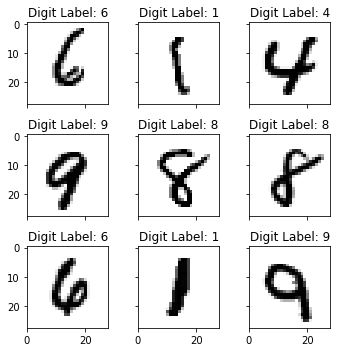

In [5]:
images_to_plot = 9
random_indices = np.random.choice(range(50000), images_to_plot)

sample_images = data["x_train_flat"][random_indices, :]
sample_labels = data["y_train"][random_indices]

plt.clf()
plt.style.use("seaborn-muted")

fig, axes = plt.subplots(3, 3, 
                         figsize=(5,5),
                         sharex=True, sharey=True,
                         subplot_kw=dict(aspect="equal"))

for i in range(images_to_plot):
    
    subplot_row = i // 3 
    subplot_col = i % 3  
    ax = axes[subplot_row, subplot_col]

    plottable_image = np.reshape(sample_images[i, :], (28, 28))
    ax.imshow(plottable_image, cmap="gray_r")
    
    ax.set_title("Digit Label: {}".format(sample_labels[i]))
    ax.set_xbound([0, 28])

plt.tight_layout()
plt.show()